In [1]:
options(max.print = 100)
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/tcea_FANTOM/tcea_FANTOM_enhancers_metadata.txt"


In [2]:
# Parameters
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"
cell_type_enhancers_path = "Analysis/10X_PBMC/cell_type_enhancers/PBMC_enhancers_id.tsv"
cell_idents_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
enhancers_metadata_path = "Analysis/enhancers/ensembl/ensembl_enhancers_metadata.txt"


In [3]:
setwd(here::here()) # set working directory to project root
getwd() 

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [4]:
library(dplyr)
library(Matrix)
library(Seurat)
library(ggplot2)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Attaching SeuratObject



‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed



In [5]:
rna_enhancers = readRDS(filtered_erna_path)

In [6]:
rna_enhancers[1:10,1:10]

  [[ suppressing 10 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                 
ENSR10_73C2H3 . . . . . . . . . .
ENSR10_73PWXH . . . . . . . . . .
ENSR10_77L6BH . . . . . . . . . .
ENSR10_77ZG22 . . . . . . . . . .
ENSR10_783P86 . . . . . . . . . .
ENSR10_78LQB3 . . . . . . . . . .
ENSR10_78M49H . . . . . . . . . .
ENSR10_792D7X . . . . . . . . . .
ENSR10_79LLCR . . . . . . . . . .
ENSR10_7QRW5  . . . . . . . . . .

In [7]:
pbmc_erna = CreateSeuratObject(counts = rna_enhancers, project = "PBMC_eRNA", min.cells = 3, min.features = 3)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [8]:
pbmc_erna

An object of class Seurat 
29683 features across 11868 samples within 1 assay 
Active assay: RNA (29683 features, 0 variable features)

[1] "ENSR7-B5NCH"   "ENSR12-93XKQW" "ENSR6-B4RFC"   "ENSR16-93DN2" 
 [5] "ENSR17-CB5Z7"  "ENSR15-C7RR4"  "ENSR2-CQL8L"   "ENSR14-BHK2N" 
 [9] "ENSR10-9ZW82"  "ENSR1-94JHHW"

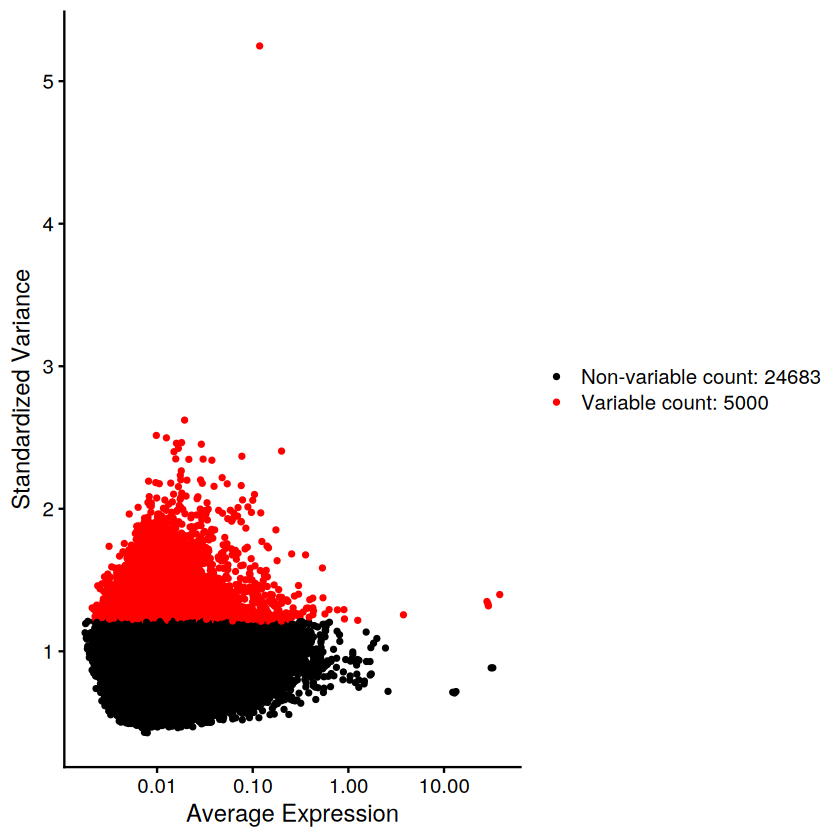

In [9]:

# Normalize and identify variable features
#pbmc_erna <- NormalizeData(pbmc_erna, normalization.method = "LogNormalize", scale.factor = 1e6)
pbmc_erna <- FindVariableFeatures(pbmc_erna, selection.method = "vst", nfeatures = 5000)

# Visualize variable features
top10 <- head(VariableFeatures(pbmc_erna), 10)
top10
VariableFeaturePlot(pbmc_erna)

Centering and scaling data matrix



PC_ 1 
Positive:  ENSR14-93GDB3, ENSR6-78C72X, ENSR12-CZ5T, ENSR18-C89GM, ENSR4-856SLT, ENSR5-9J88C, ENSR4-93KWXT, ENSR1-CSHGF, ENSR12-9NQ3N, ENSR17-BCK3N 
	   ENSR17-BBDDD, ENSR14-C84GQ, ENSR14-C84CD, ENSR6-93BQG7, ENSR10-C85XP, ENSR1-C4CBP, ENSR14-BPNH9, ENSR2-B3PJ9L, ENSRX-BF983, ENSR15-CCRHR 
	   ENSR6-CJ6MB, ENSR19-C398M, ENSR5-BKWWB, ENSR4-9KXW5, ENSR12-83XM4Z, ENSR22-836NC2, ENSR2-C522H, ENSR5-CFSMK, ENSR4-BRGC6, ENSR18-9X4XF 
Negative:  ENSR21-CS28, ENSR21-DF3P, ENSR21-CSHH, ENSR5-D9GH7, ENSR21-B3R6D, ENSR2-93MR7W, ENSR19-C6HR7, ENSR17-BFTCH, ENSR11-C83TJ, ENSR2-945BZ5 
	   ENSR9-93S338, ENSR11-C97TQ, ENSR17-BBKQZ, ENSR11-BFZG6, ENSR16-CB4DJ, ENSR19-B37J6, ENSR14-934TS9, ENSR1-B34W44, ENSR13-C44BC, ENSR20-B5XJT 
	   ENSR19-996T6, ENSR19-97P6H, ENSR6-9D3PF, ENSR17-9DXR5, ENSR3-9466GB, ENSR20-B5X8N, ENSR12-BT5QF, ENSR10-93SN9L, ENSR12-BHKC8, ENSR1-B3SGS 
PC_ 2 
Positive:  ENSR21-B3R6D, ENSR21-DF3P, ENSR21-CSHH, ENSR21-CS28, ENSR14-93GDB3, ENSR4-856SLT, ENSR4-93KWXT, ENSR5-C9XZD, 

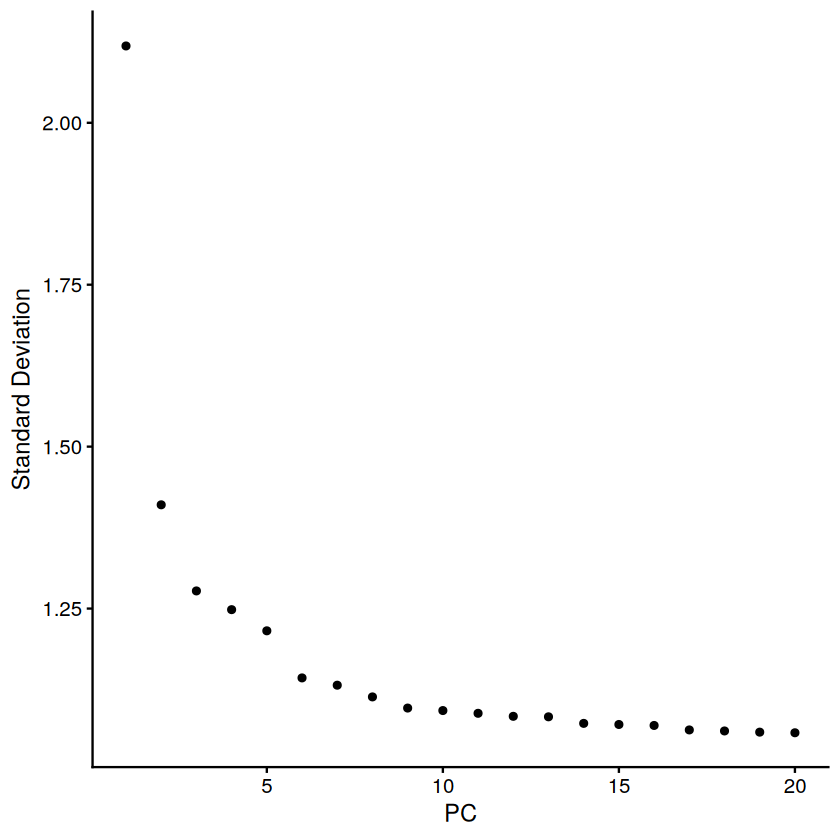

In [10]:
# Scale, PCA
pbmc_erna <- ScaleData(pbmc_erna, features = VariableFeatures(pbmc_erna))
pbmc_erna <- RunPCA(pbmc_erna, features = VariableFeatures(object = pbmc_erna))
ElbowPlot(pbmc_erna)



In [11]:
# Neighborhood graph, clustering and UMAP
pbmc_erna <- FindNeighbors(pbmc_erna, dims = 1:10)
pbmc_erna <- FindClusters(pbmc_erna, resolution = 0.2)



Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11868
Number of edges: 367154

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9048
Number of communities: 6
Elapsed time: 3 seconds


In [12]:
pbmc_erna <- RunUMAP(pbmc_erna, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


18:48:35 UMAP embedding parameters a = 0.9922 b = 1.112



18:48:35 Read 11868 rows and found 10 numeric columns



18:48:35 Using Annoy for neighbor search, n_neighbors = 30



18:48:35 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%



[----|----|----|----|----|----|----|----|----|----|



*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


*


|



18:48:37 Writing NN index file to temp file /tmp/RtmppUkHsz/file3a7ef91cc8f39d



18:48:37 Searching Annoy index using 1 thread, search_k = 3000



18:48:43 Annoy recall = 100%



18:48:43 Commencing smooth kNN distance calibration using 1 thread


 with target n_neighbors = 30



18:48:45 Initializing from normalized Laplacian + noise (using irlba)



18:48:45 Commencing optimization for 200 epochs, with 489964 positive edges



18:48:45 Using rng type: pcg



18:48:51 Optimization finished



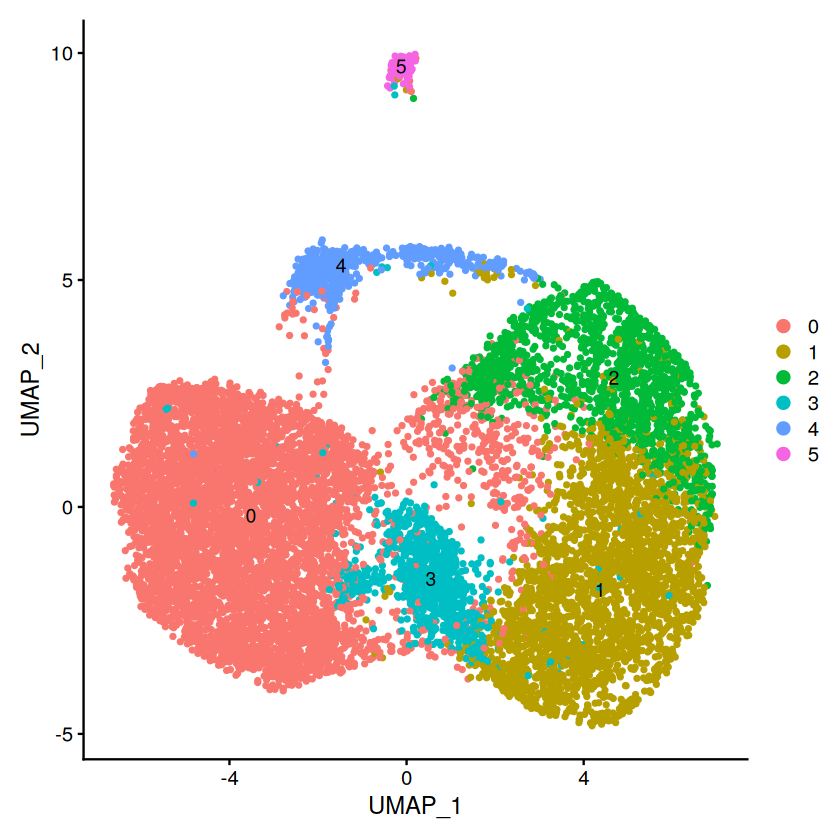

In [13]:
# Plot UMAP
DimPlot(pbmc_erna, reduction = "umap", label = TRUE,pt.size = 1) 

In [14]:
cell_type_idents = readRDS(cell_idents_path)
rownames(cell_type_idents) = gsub("-1","",rownames(cell_type_idents))
head(cell_type_idents)

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACAGCCACACTAAT,cd8
AAACAGCCACCAACCG,cd8
AAACAGCCAGGATAAC,cd4
AAACAGCCAGTTTACG,cd4


In [15]:
unique(cell_type_idents[1])

,pbmc@active.ident
,<fct>
AAACAGCCAATCCCTT,cd4
AAACAGCCAATGCGCT,cd8
AAACATGCACCGGCTA,undefined_t_cells
AAACCAACACAATGCC,cd14
AAACCGAAGCTGGACC,cd4_in_cd14
AAAGCAAGTTAACGGC,b_cells
AACAGATAGTAACCCG,cd4_near_b


In [16]:
pbmc_erna  = AddMetaData(object = pbmc_erna, metadata = cell_type_idents,col.name = "cell_type")

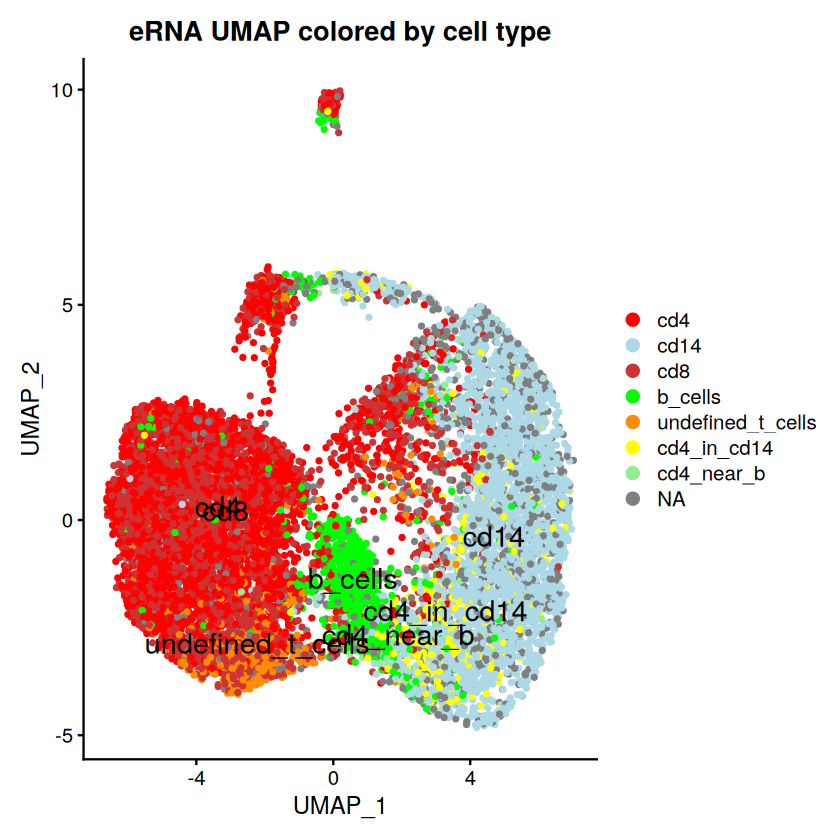

In [17]:
DimPlot(pbmc_erna, reduction = "umap", group.by = "cell_type", label = TRUE,pt.size = 1,label.size = 6)+ 
  ggtitle("eRNA UMAP colored by cell type")+
  #set colors
  scale_color_manual(values =c(
    "cd4" = "red",
    "cd8" = "brown3",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "lightblue",
    "other" = "gray"  # Add other cell types here if needed
))


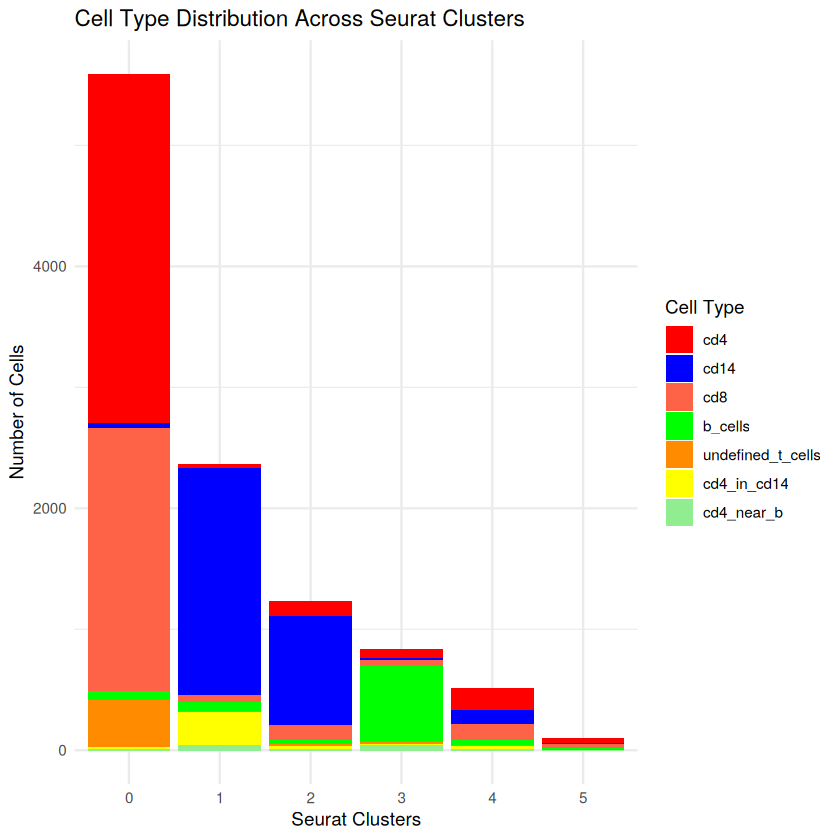

In [18]:
#stacked barplot of cell types per cluster
cluster_celltype_table = table(pbmc_erna$seurat_clusters, pbmc_erna$cell_type)
cluster_celltype_df = as.data.frame(cluster_celltype_table)

ggplot(cluster_celltype_df, aes(x=Var1, y=Freq, fill=Var2)) +
    geom_bar(stat="identity") +
    labs(x="Seurat Clusters", y="Number of Cells", fill="Cell Type") +
    ggtitle("Cell Type Distribution Across Seurat Clusters") +
    theme_minimal()+
    scale_fill_manual(values = c(
    "cd4" = "red",
    "cd8" = "tomato1",
    "undefined_t_cells" = "darkorange",
    "cd4_in_cd14" = "yellow",
    "cd4_near_b" = "lightgreen",
    "b_cells" = "green",
    "cd14" = "blue",
    "other" = "gray"  # Add other cell types here if needed
))

In [19]:
cluster_0_vs_cluster1_markers = FindMarkers(pbmc_erna, ident.1 = 0, ident.2 = 1, min.pct = 0)


For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [20]:
dim(cluster_0_vs_cluster1_markers)
head(cluster_0_vs_cluster1_markers,20)

[1] 27183     5

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSR10-BHP86,0.000000e+00,20.471058,0.067,0.419,0.000000e+00
ENSR17-D45XB,0.000000e+00,63.139562,0.022,0.368,0.000000e+00
ENSR21-CS28,0.000000e+00,14.415189,0.801,0.981,0.000000e+00
ENSR21-CSHH,0.000000e+00,35.451133,0.798,0.978,0.000000e+00
ENSR21-DF3P,0.000000e+00,7.331700,0.810,0.977,0.000000e+00
ENSR5-B34SXH,0.000000e+00,-7.943685,0.020,0.448,0.000000e+00
ENSR5-D9GH7,0.000000e+00,-65.571564,0.066,0.767,0.000000e+00
ENSR6-B4RN5,0.000000e+00,-13.430002,0.021,0.399,0.000000e+00
ENSR6-B4RND,0.000000e+00,-16.277572,0.025,0.482,0.000000e+00


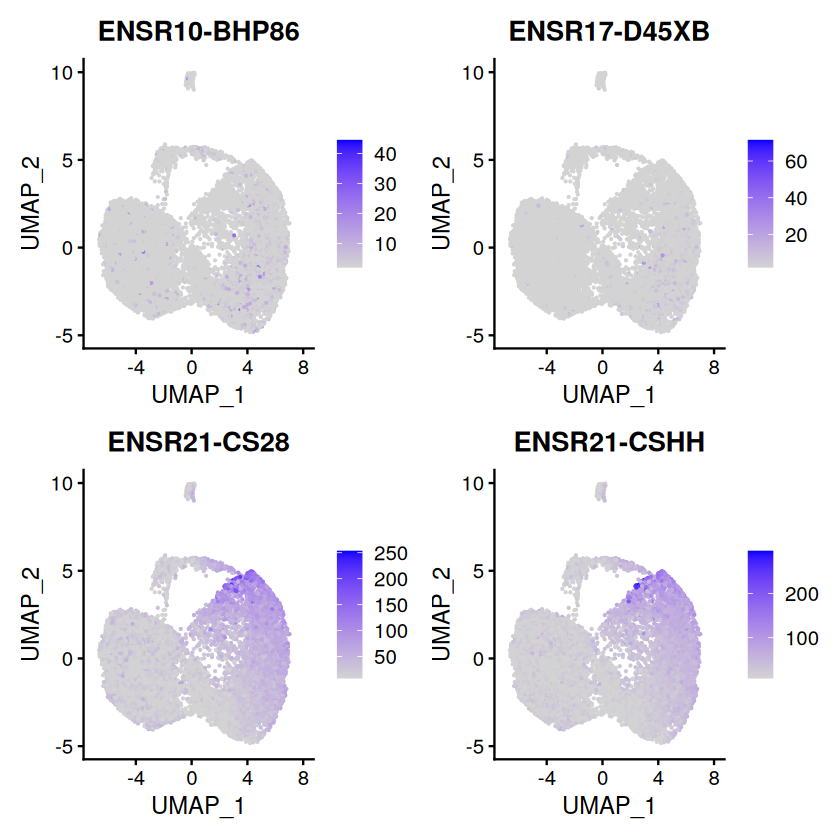

In [21]:
FeaturePlot(pbmc_erna, features = rownames(cluster_0_vs_cluster1_markers)[1:4], min.cutoff = "q9")

In [22]:
top_de_enhancers = rownames(head(cluster_0_vs_cluster1_markers,20)) %>% gsub("-","_",.)
top_de_enhancers

[1] "ENSR10_BHP86"  "ENSR17_D45XB"  "ENSR21_CS28"   "ENSR21_CSHH"  
 [5] "ENSR21_DF3P"   "ENSR5_B34SXH"  "ENSR5_D9GH7"   "ENSR6_B4RN5"  
 [9] "ENSR6_B4RND"   "ENSR7_855D25"  "ENSR9_C98ZW"   "ENSR10_C8T4T" 
[13] "ENSR2_C625T"   "ENSR7_8465MG"  "ENSR7_847MWW"  "ENSR7_847CXD" 
[17] "ENSR8_C7K26"   "ENSR12_93BL9Z" "ENSR2_93MR7W"  "ENSR12_83XKN5"

In [23]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = FALSE)

In [24]:
enhancers_metadata

chr,start,end,id,type,gene_intersection,bp_to_closest_gene,length
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,11436,11649,ENSR1_88N,1,intergenic,53770,213
1,12685,14671,ENSR1_CZ,1,intergenic,50748,1986
1,15100,15853,ENSR1_B48,1,intergenic,49566,753
1,21128,21603,ENSR1_986,1,intergenic,43816,475
1,25830,26342,ENSR1_B5Q,1,intergenic,39077,512
1,28599,29332,ENSR1_B67,1,intergenic,36087,733
1,30539,30813,ENSR1_9BT,1,intergenic,34606,274
1,31906,32843,ENSR1_B6N,1,intergenic,32576,937
1,34247,35149,ENSR1_B72,1,intergenic,30270,902


In [25]:
# deg = cluster_0_vs_cluster1_markers %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > 2)
# enhancers_metadata$id = gsub("_","-",enhancers_metadata$id)
# rownames(enhancers_metadata) = enhancers_metadata$id
# #barplot how many are intergenic or intragenic
# deg_metadata = enhancers_metadata[match(rownames(deg), enhancers_metadata$id), ]
# table(deg_metadata$gene_intersection )